In [1]:
import wrangle

import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from env import user, password, host
import env
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import csv
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
zillow_train,zillow_validate,zillow_test=wrangle.wrangled_file()

In [3]:
zillow_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39691 entries, 25431 to 28555
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   bathroom                    39691 non-null  float64
 1   bedroom                     39691 non-null  float64
 2   calculatedbathnbr           39691 non-null  float64
 3   sqtft                       39691 non-null  float64
 4   finishedsquarefeet12        39691 non-null  float64
 5   fips                        39691 non-null  object 
 6   fullbathcnt                 39691 non-null  float64
 7   latitude                    39691 non-null  float64
 8   longitude                   39691 non-null  float64
 9   propertycountylandusecode   39691 non-null  object 
 10  rawcensustractandblock      39691 non-null  float64
 11  zipcode                     39691 non-null  object 
 12  roomcnt                     39691 non-null  float64
 13  yearbuilt                  

In [4]:
zillow_train.describe().T

,count,mean,std,min,25%,50%,75%,max
bathroom,39691.0,2.208108e+00,7.992269e-01,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,5.500000e+00
bedroom,39691.0,2.968532e+00,9.634240e-01,0.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,7.000000e+00
calculatedbathnbr,39691.0,2.208108e+00,7.992269e-01,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,5.500000e+00
sqtft,39691.0,1.660580e+03,6.900463e+02,2.970000e+02,1.163000e+03,1.500000e+03,2.009000e+03,3.998000e+03
finishedsquarefeet12,39691.0,1.660580e+03,6.900463e+02,2.970000e+02,1.163000e+03,1.500000e+03,2.009000e+03,3.998000e+03
fullbathcnt,39691.0,2.142375e+00,7.899029e-01,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,5.000000e+00
latitude,39691.0,3.401117e+07,2.689131e+05,3.333953e+07,3.381269e+07,3.402360e+07,3.417945e+07,3.481240e+07
longitude,39691.0,-1.182014e+08,3.626229e+05,-1.194753e+08,-1.184209e+08,-1.181702e+08,-1.179244e+08,-1.175546e+08
rawcensustractandblock,39691.0,6.049387e+07,2.076241e+05,6.037101e+07,6.037401e+07,6.037621e+07,6.059042e+07,6.111009e+07
roomcnt,39691.0,1.554559e+00,2.854402e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.300000e+01


In [5]:
def scale(scaler,zillow_train,cols=['bedroom','bathroom','sqtft','fullbathcnt',],return_scaler=True):
    zillow_train=zillow_train
    zillow_train_scaled=zillow_train.copy()
    scaler=scaler
    zillow_train_scaled[cols] = scaler.fit_transform(zillow_train[cols])
    return scaler, zillow_train_scaled

In [6]:
scaler,zillow_scaled=scale(MinMaxScaler(),zillow_train)

In [7]:
zillow_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39691 entries, 25431 to 28555
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   bathroom                    39691 non-null  float64
 1   bedroom                     39691 non-null  float64
 2   calculatedbathnbr           39691 non-null  float64
 3   sqtft                       39691 non-null  float64
 4   finishedsquarefeet12        39691 non-null  float64
 5   fips                        39691 non-null  object 
 6   fullbathcnt                 39691 non-null  float64
 7   latitude                    39691 non-null  float64
 8   longitude                   39691 non-null  float64
 9   propertycountylandusecode   39691 non-null  object 
 10  rawcensustractandblock      39691 non-null  float64
 11  zipcode                     39691 non-null  object 
 12  roomcnt                     39691 non-null  float64
 13  yearbuilt                  

In [8]:
zillow_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
bathroom,39691.0,2.684684e-01,1.776060e-01,0.000000e+00,2.222222e-01,2.222222e-01,4.444444e-01,1.000000e+00
bedroom,39691.0,4.240760e-01,1.376320e-01,0.000000e+00,2.857143e-01,4.285714e-01,5.714286e-01,1.000000e+00
calculatedbathnbr,39691.0,2.208108e+00,7.992269e-01,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,5.500000e+00
sqtft,39691.0,3.684356e-01,1.864486e-01,0.000000e+00,2.339908e-01,3.250473e-01,4.625777e-01,1.000000e+00
finishedsquarefeet12,39691.0,1.660580e+03,6.900463e+02,2.970000e+02,1.163000e+03,1.500000e+03,2.009000e+03,3.998000e+03
fullbathcnt,39691.0,2.855937e-01,1.974757e-01,0.000000e+00,2.500000e-01,2.500000e-01,5.000000e-01,1.000000e+00
latitude,39691.0,3.401117e+07,2.689131e+05,3.333953e+07,3.381269e+07,3.402360e+07,3.417945e+07,3.481240e+07
longitude,39691.0,-1.182014e+08,3.626229e+05,-1.194753e+08,-1.184209e+08,-1.181702e+08,-1.179244e+08,-1.175546e+08
rawcensustractandblock,39691.0,6.049387e+07,2.076241e+05,6.037101e+07,6.037401e+07,6.037621e+07,6.059042e+07,6.111009e+07
roomcnt,39691.0,1.554559e+00,2.854402e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.300000e+01


## Question 1
- Whether there has relationship between LogError and Age

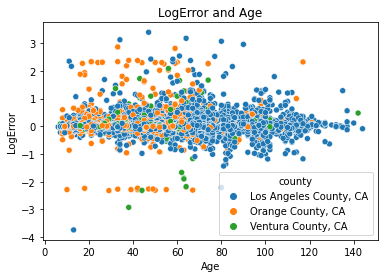

In [9]:
# plot age by logerror
sns.scatterplot(x=zillow_train.age, y=zillow_train.logerror,hue=zillow_train.county)
plt.xlabel("Age")
plt.ylabel("LogError")
plt.title("LogError and Age")
plt.show()

## Key Takeaway
- The age and log error don't seem to have any significant relationship in county when they pass age 80.
- Majority of them within 60 years built has significant log error with orange county
- The next step exploration would be whether there are signicant relationship with the taxrate and logerror

## Question 2
- Whether there has relationship between taxrate and logerror 

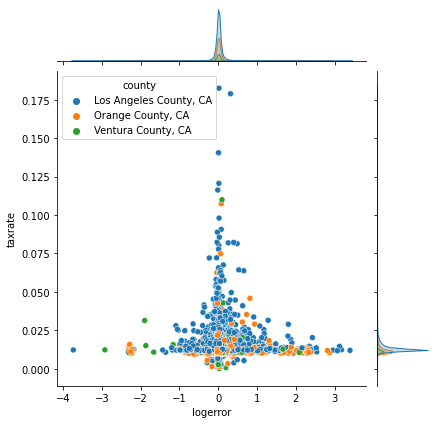

In [10]:
sns.jointplot(y="taxrate", x="logerror", data=zillow_train, hue = 'county')
plt.xlabel("county")
plt.ylabel("Logerror")
plt.show()

## Key Takeaway
- The logerror has showing significant with orange county, which is like what happened to the age
- The next step would be focusing on orange county to explore further for the reason of logerror

In [11]:
alpha = .05

In [12]:
zillow_train.county.value_counts()

Los Angeles County, CA    25653
Orange County, CA         10759
Ventura County, CA         3279
Name: county, dtype: int64

In [13]:
import scipy.stats as stats
orange = zillow_train[zillow_train.county== 'Orange County, CA'].logerror
other = zillow_train[zillow_train.county!='Orange County, CA'].logerror
orange.var(), other.var()

(0.03204939661794507, 0.022311007415905984)

In [14]:
t, p = stats.ttest_ind(orange, other, equal_var=False)
print(t, p/2, alpha)

2.10787215888906 0.017528484583230128 0.05


In [15]:
if p/2 > alpha:
    print("We fail to reject H0")
elif t < 0:
    print("We fail to reject H0")
else:
    print("We reject H0 ")

We reject H0 


## Key Takeaway
- The orange county has significant different on the logerror compare to the other counties
- The orange county has 59.9% variable higher than other countiers 

## Question 4
- Is there a significant different between logerror and the bathroom and bedroom counts 

Is there a relationship
between room count and logerror?


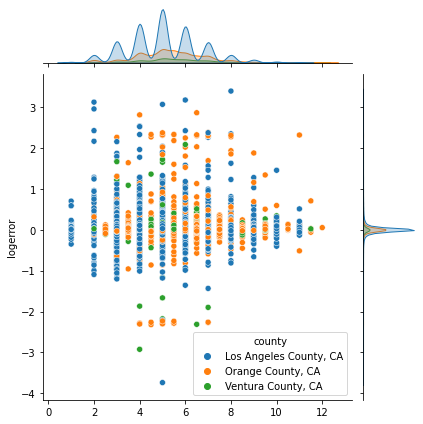

In [16]:
#creating a joinplot to see if any linear relationship
print("Is there a relationship\nbetween room count and logerror?")
room=zillow_train['bathroom']+zillow_train['bedroom']
sns.jointplot(x=room, y='logerror', data=zillow_train, hue = 'county')
plt.xlabel("Room")
plt.ylabel("Logerror")
plt.show()

In [17]:
zillow_train[zillow_train.logerror>=1.5].county.value_counts()

Orange County, CA         34
Los Angeles County, CA    27
Ventura County, CA         4
Name: county, dtype: int64

## Key Takeaway
- The orange county has significant higher logerror
- The orange county has higher logerror with room count between 3-8
- The logerror plays significant role on logerror
- Would recommend doing the prediction seperately with orange county to be one and rest of the county to be the other one

## Question 5
- Can we achieve lower logerror when seperate orange county out of overall 

<AxesSubplot:xlabel='county'>

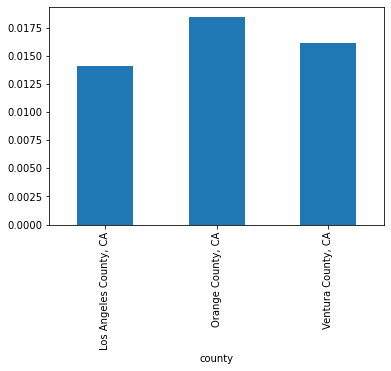

In [18]:
zillow_train.groupby('county').logerror.mean().plot.bar()

In [19]:
nroom=zillow_train.bathroom+zillow_train.bedroom
zillow_train['county1']=zillow_train['county'].replace(['Los Angeles County, CA', 'Ventura County, CA'], 'Other')

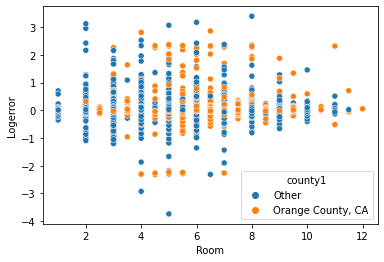

In [20]:
sns.scatterplot(x=nroom, y='logerror', data=zillow_train, hue='county1')
plt.xlabel("Room")
plt.ylabel("Logerror")
plt.show()

In [21]:
zillow_train.logerror.mean()-zillow_train[zillow_train.county1=='Other'].logerror.mean()


0.00110647011264536

## Key Takeaway
- If we remove the orange county, the logerror doesn't have significant change
- The modeling would not remove the orange county

# Cluster

In [42]:
scaled_train,scaled_validate,scaled_test=wrangle.scale_data(zillow_train,zillow_validate,zillow_test,cols=['bathroom','bedroom','taxrate','month','age','sqtft'])

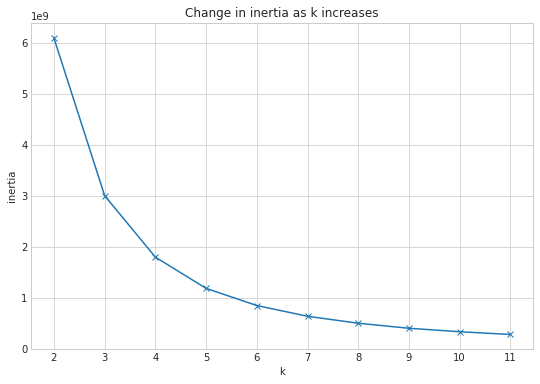

In [43]:
# building and X to start clustering
from sklearn.cluster import KMeans
X = scaled_train[['bathroom','bedroom','taxrate','month','age','sqtft']]
with plt.style.context('seaborn-whitegrid'):
    #graph size
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [47]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

kmeans.predict(X)
scaled_train['cluster']= kmeans.predict(X)


In [48]:
zillow_train.T

,25431,38250,49562,70863,42668,46749,2537,30241,65130,18543,...,75575,57978,58696,45679,40674,31964,27743,47425,56934,28555
bathroom,3.0,3.0,1.0,2.0,5.0,1.0,1.0,1.0,2.0,2.5,...,2.0,1.0,2.0,4.0,1.0,1.0,2.0,2.0,2.5,2.5
bedroom,3.0,4.0,2.0,2.0,5.0,3.0,1.0,3.0,3.0,2.0,...,4.0,2.0,2.0,4.0,3.0,2.0,2.0,3.0,4.0,4.0
calculatedbathnbr,3.0,3.0,1.0,2.0,5.0,1.0,1.0,1.0,2.0,2.5,...,2.0,1.0,2.0,4.0,1.0,1.0,2.0,2.0,2.5,2.5
sqtft,1980.0,1888.0,933.0,1155.0,3507.0,1037.0,686.0,1068.0,1877.0,1442.0,...,1388.0,1272.0,1158.0,3414.0,1346.0,882.0,899.0,1559.0,2064.0,2086.0
finishedsquarefeet12,1980.0,1888.0,933.0,1155.0,3507.0,1037.0,686.0,1068.0,1877.0,1442.0,...,1388.0,1272.0,1158.0,3414.0,1346.0,882.0,899.0,1559.0,2064.0,2086.0
fips,6037.0,6059.0,6037.0,6037.0,6037.0,6037.0,6059.0,6037.0,6037.0,6111.0,...,6059.0,6037.0,6037.0,6037.0,6037.0,6059.0,6037.0,6037.0,6059.0,6059.0
fullbathcnt,3.0,3.0,1.0,2.0,5.0,1.0,1.0,1.0,2.0,2.0,...,2.0,1.0,2.0,4.0,1.0,1.0,2.0,2.0,2.0,2.0
latitude,34140554.0,33806286.0,34102900.0,34035300.0,34143518.0,34009961.0,33660900.0,33943427.0,34090261.0,34189433.0,...,33763579.0,34030655.0,33958694.0,34075887.0,33867635.0,33865096.0,34209200.0,34084789.0,33587411.0,33682243.0
longitude,-117747943.0,-117968820.0,-117750000.0,-118469000.0,-118439788.0,-118073407.0,-117645000.0,-118032525.0,-117860542.0,-119227450.0,...,-117978349.0,-118346053.0,-118125626.0,-117845362.0,-118170594.0,-117792876.0,-118575000.0,-117914056.0,-117585601.0,-117779112.0
propertycountylandusecode,010D,122,010C,010E,0101,0100,34,0100,0101,1129,...,122,0100,0101,0100,0100,34,010E,0100,122,122


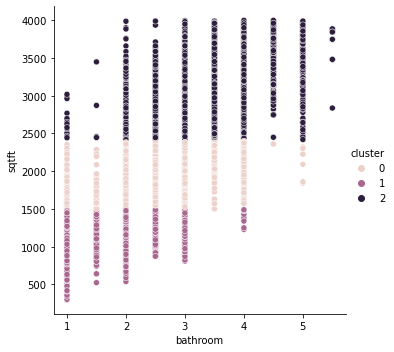

In [49]:
sns.relplot(data=scaled_train, 
            x='bathroom', 
            y='sqtft',
           hue='cluster');

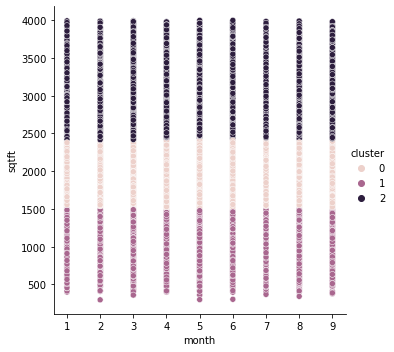

In [56]:
sns.relplot(data=scaled_train, 
            x='month', 
            y='sqtft',
           hue='cluster');

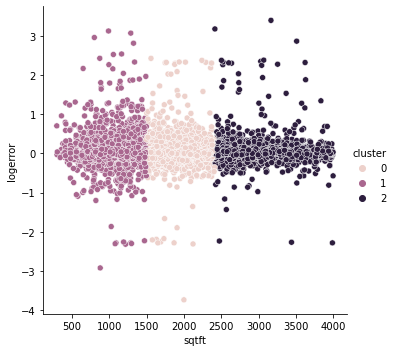

In [60]:
sns.relplot(data=scaled_train, 
            x='sqtft', 
            y='logerror',
           hue='cluster');

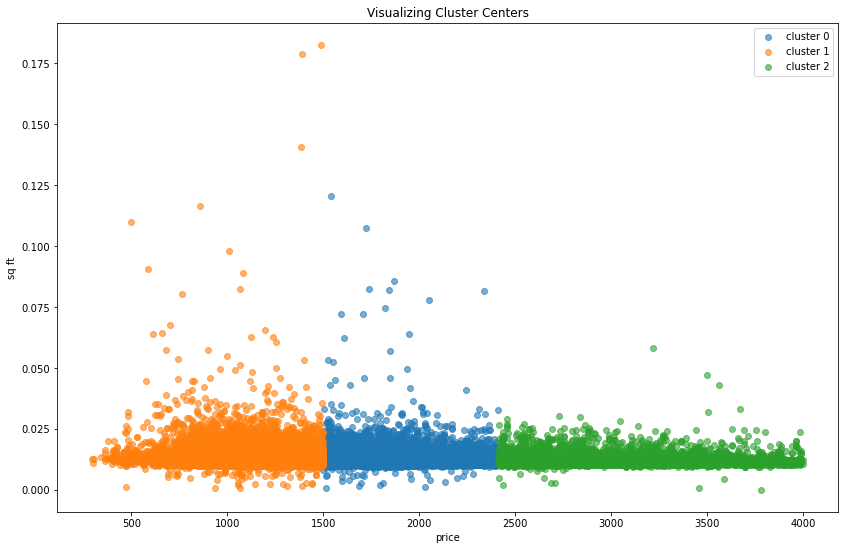

In [68]:
#graph size 
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
plt.figure(figsize=(14, 9))
#graphing after weve clustered using a scatter plot
for cluster, subset in scaled_train.groupby('cluster'):

        plt.scatter(subset.sqtft, subset.taxrate, label='cluster ' + str(cluster), alpha=.6)

        plt.legend()
        plt.xlabel('price')
        plt.ylabel('sq ft')
        plt.title('Visualizing Cluster Centers')